https://www.youtube.com/watch?v=44U8jJxaNp8

https://keras-team.github.io/keras-tuner/

## import necessary libraries

In [1]:
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')

In [2]:
import os
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'    # ignore information messages

import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model, callbacks
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import (SparseCategoricalAccuracy, Precision, Recall, AUC, 
                                      FalsePositives, FalseNegatives, TruePositives, TrueNegatives)

import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow_datasets as tfds
# tfds.disable.progress_bar()

## find datasets

In [ ]:
tfds.list_builders()

## get information on the data

In [ ]:
builder = tfds.builder('rock_paper_scissors')

info = builder.info
info

## prepare rock, paper, scissors data

In [4]:
ds_train = tfds.load(name='rock_paper_scissors', split='train')
ds_test = tfds.load(name='rock_paper_scissors', split='test')

In [5]:
ds_train

<PrefetchDataset shapes: {image: (300, 300, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

## show examples

In [ ]:
fig = tfds.show_examples(ds_train, info)

## additional data prep

In [6]:
train_images = [example['image'] for example in ds_train]
type(train_images[0])

tensorflow.python.framework.ops.EagerTensor

In [7]:
train_images = np.array([example['image'].numpy() for example in ds_train])
type(train_images[0])

numpy.ndarray

In [8]:
train_images.shape

(2520, 300, 300, 3)

In [9]:
train_images = np.array([example['image'].numpy()[:, :, 0] for example in ds_train])
train_labels = np.array([example['label'].numpy() for example in ds_train])

test_images = np.array([example['image'].numpy()[:, :, 0] for example in ds_test])
test_labels = np.array([example['label'].numpy() for example in ds_test])

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(2520, 300, 300)
(2520,)
(372, 300, 300)
(372,)


In [10]:
img_height = img_width = 28
def resize_images(img):
    img = cv2.resize(img, (img_height, img_width))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    # to read images grayscale
    img = np.reshape(img, (img_height, img_width, 1))
    return img

In [11]:
train_images = np.array([resize_images(img) for img in train_images])
test_images = np.array([resize_images(img) for img in test_images])

print(train_images.shape)
print(test_images.shape)

(2520, 28, 28, 1)
(372, 28, 28, 1)


(2520, 300, 300, 1) -> add 1 to keras for gray scale

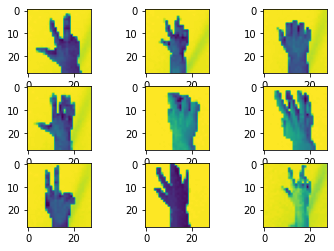

In [12]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(array_to_img(train_images[i]))
plt.show()

In [13]:
# scaling every value between 0-1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [14]:
train_images[0].shape

(28, 28, 1)

## train a network (basic approach)

In [18]:
model = Sequential([
    Flatten(),
    Dense(521, activation='relu'),
    Dense(256, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
             loss=SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [19]:
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, 
                    batch_size=32)

Epoch 1/10
79/79 [==============================] - 1s 8ms/step - loss: 1.2714 - accuracy: 0.4328 - val_loss: 1.0929 - val_accuracy: 0.4409
Epoch 2/10
79/79 [==============================] - 0s 5ms/step - loss: 0.7745 - accuracy: 0.6615 - val_loss: 1.1156 - val_accuracy: 0.4624
Epoch 3/10
79/79 [==============================] - 1s 6ms/step - loss: 0.5065 - accuracy: 0.8265 - val_loss: 0.9887 - val_accuracy: 0.5941
Epoch 4/10
79/79 [==============================] - 1s 7ms/step - loss: 0.4063 - accuracy: 0.8556 - val_loss: 1.2909 - val_accuracy: 0.4651
Epoch 5/10
79/79 [==============================] - 1s 6ms/step - loss: 0.2539 - accuracy: 0.9277 - val_loss: 1.2702 - val_accuracy: 0.5887
Epoch 6/10
79/79 [==============================] - 1s 7ms/step - loss: 0.1712 - accuracy: 0.9481 - val_loss: 1.4021 - val_accuracy: 0.6398
Epoch 7/10
79/79 [==============================] - 1s 7ms/step - loss: 0.1587 - accuracy: 0.9501 - val_loss: 2.0811 - val_accuracy: 0.4704
Epoch 8/10
79/79 [==

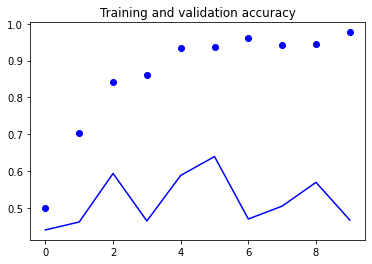

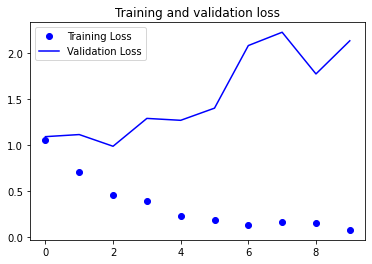

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Basically we are overfitting to our training data.

## train a network (convolutional approach)

In [23]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3)(inputs)
x = BatchNormalization()(x)
x = relu(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3)(x)
x = BatchNormalization()(x)
x = relu(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3)(x)
x = BatchNormalization()(x)
x = relu(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [24]:
model.compile(optimizer='adam',
             loss=SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [25]:
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=30, 
                    batch_size=16)

Epoch 1/30
158/158 [==============================] - 1s 6ms/step - loss: 0.3600 - accuracy: 0.8693 - val_loss: 1.1171 - val_accuracy: 0.4247
Epoch 2/30
158/158 [==============================] - 1s 5ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 1.0470 - val_accuracy: 0.5215
Epoch 3/30
158/158 [==============================] - 1s 6ms/step - loss: 4.8547e-04 - accuracy: 1.0000 - val_loss: 1.0210 - val_accuracy: 0.6694
Epoch 4/30
158/158 [==============================] - 1s 6ms/step - loss: 2.1456e-04 - accuracy: 1.0000 - val_loss: 0.8551 - val_accuracy: 0.6882
Epoch 5/30
158/158 [==============================] - 1s 6ms/step - loss: 1.3441e-04 - accuracy: 1.0000 - val_loss: 0.7738 - val_accuracy: 0.6801
Epoch 6/30
158/158 [==============================] - 1s 6ms/step - loss: 9.1989e-05 - accuracy: 1.0000 - val_loss: 0.7492 - val_accuracy: 0.6909
Epoch 7/30
158/158 [==============================] - 1s 6ms/step - loss: 6.3143e-05 - accuracy: 1.0000 - val_loss: 0.7445 - val_acc

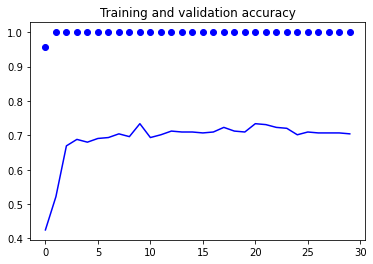

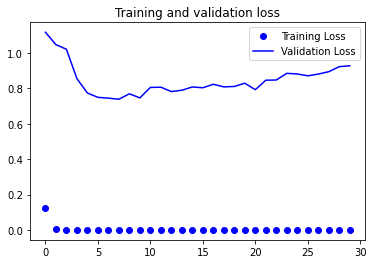

In [26]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='sigmoid')
])

##################

model.compile(optimizer='adam',
             loss=SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

##################

history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=30, 
                    batch_size=16)

Epoch 1/30
158/158 [==============================] - 1s 5ms/step - loss: 1.1156 - accuracy: 0.5593 - val_loss: 2.7977 - val_accuracy: 0.3333
Epoch 2/30
158/158 [==============================] - 1s 5ms/step - loss: 0.5128 - accuracy: 0.7849 - val_loss: 3.0577 - val_accuracy: 0.3333
Epoch 3/30
158/158 [==============================] - 1s 6ms/step - loss: 0.2711 - accuracy: 0.9045 - val_loss: 1.2282 - val_accuracy: 0.5215
Epoch 4/30
158/158 [==============================] - 1s 6ms/step - loss: 0.1957 - accuracy: 0.9325 - val_loss: 0.9569 - val_accuracy: 0.7097
Epoch 5/30
158/158 [==============================] - 1s 6ms/step - loss: 0.1397 - accuracy: 0.9497 - val_loss: 0.2581 - val_accuracy: 0.8898
Epoch 6/30
158/158 [==============================] - 1s 6ms/step - loss: 0.1117 - accuracy: 0.9623 - val_loss: 0.4983 - val_accuracy: 0.8226
Epoch 7/30
158/158 [==============================] - 1s 6ms/step - loss: 0.0995 - accuracy: 0.9628 - val_loss: 0.3415 - val_accuracy: 0.8629
Epoch 

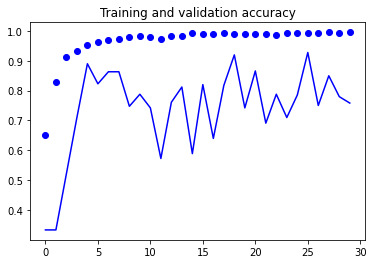

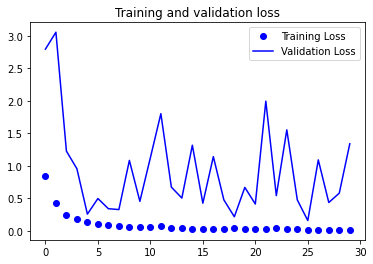

In [28]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## save and load the model

In [30]:
model.save('rock_paper_scissors_saved.model')

/Users/onurkaraguler/miniforge3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/onurkaraguler/miniforge3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: rock_paper_scissors_saved.model/assets


INFO:tensorflow:Assets written to: rock_paper_scissors_saved.model/assets


In [15]:
model = load_model('rock_paper_scissors_saved.model')

In [18]:
test_images[0].shape

(28, 28, 1)

In [23]:
y_predicted = model.predict(test_images)

predicted:  0
truth:  0


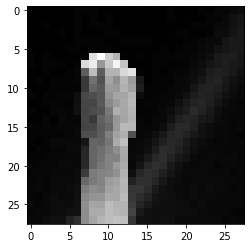

In [34]:
num = 3
y_predicted[num]
print('predicted: ', np.argmax(y_predicted[num]))

print('truth: ', test_labels[num])

plt.imshow(test_images[num], cmap=plt.cm.binary)
plt.show()
# print(x_train[0])

In [29]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=test_labels,predictions=y_predicted_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[124,   0,   0],
       [ 68,  56,   0],
       [  9,  13, 102]], dtype=int32)>

Text(69.0, 0.5, 'Truth')

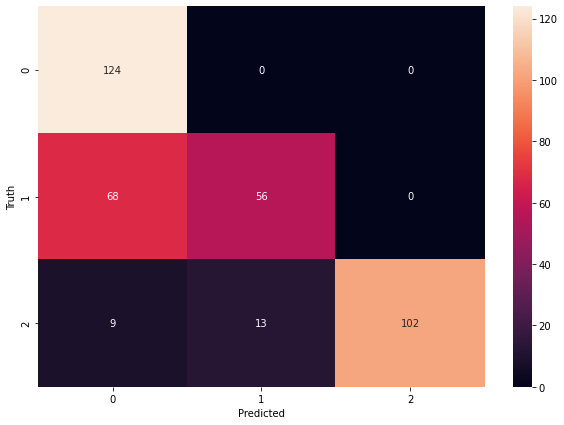

In [30]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')